In [1]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import seaborn as sns
import matplotlib.pyplot as plt

/home/acicalo/miniconda3/envs/pyscenic/lib/python3.10/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/acicalo/miniconda3/envs/pyscenic/lib/python3.10/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/hom

In [2]:
# set variables for file paths to read from and write to:

# set a working directory
wdir = "/mnt/data0/projects/biohub/hassan2022/output/SCENIC/pyscenic_workflow/MBON/output/TauKI/"
os.chdir( wdir )

# path to unfiltered loom file (this will be created in the optional steps below)
# # path to loom file with basic filtering applied (this will be created in the "initial filtering" step below). Optional.
f_loom_path_scenic = "MBON_TauKI_filtered_scenic.loom"

# path to anndata object, which will be updated to store Scanpy results as they are generated below
f_anndata_path = "MBON_TauKI_anndata.h5ad"

# path to pyscenic output
f_pyscenic_output = "MBON_TauKI_pyscenic_output.loom"

# loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = 'MBON_TauKI_scenic_integrated-output.loom'

In [3]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)

-----
anndata     0.9.1
scanpy      1.9.3
-----
MulticoreTSNE               NA
PIL                         9.5.0
asttokens                   NA
backcall                    0.2.0
cffi                        1.15.1
cloudpickle                 2.2.1
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.12.1
dask                        2023.5.0
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
entrypoints                 0.4
executing                   1.2.0
h5py                        3.8.0
ipykernel                   6.15.0
jedi                        0.18.2
jinja2                      3.1.2
joblib                      1.2.0
kiwisolver                  1.4.4
llvmlite                    0.40.0
loompy                      3.0.7
lz4                         4.3.2
markupsafe                  2.1.2
matplotlib                  3.7.1
mpl_toolkits                NA
natsort                     8.3.1
numba

In [4]:
# Set maximum number of jobs for Scanpy.
sc.settings.njobs = 20

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
f_loom_path_unfilt = "/mnt/data0/projects/biohub/hassan2022/output/SCENIC/pyscenic_workflow/MBON/unfiltered_loom/MBON_P251L.loom"
# read unfiltered data from a loom file
adata = sc.read_loom( f_loom_path_unfilt )

In [8]:
louvain = adata.obs["seurat_clusters"]

In [9]:
adata.obs["louvain"] = louvain

In [11]:
# read in the embedding files from Seurat
pca = pd.read_csv('/mnt/data0/projects/biohub/hassan2022/output/SCENIC/pyscenic_workflow/MBON/embedding_files/pca_P251L.csv')
umap = pd.read_csv('/mnt/data0/projects/biohub/hassan2022/output/SCENIC/pyscenic_workflow/MBON/embedding_files/umap_P251L.csv')
PC1 = pca["PC_1"]
PC2 = pca["PC_2"]
PC3 = pca["PC_3"]
PC4 = pca["PC_4"]
PC5 = pca["PC_5"]
PC6 = pca["PC_6"]
PC7 = pca["PC_7"]
PC8 = pca["PC_8"]
PC9 = pca["PC_9"]
PC10 = pca["PC_10"]
PC11 = pca["PC_11"]
PC12 = pca["PC_12"]
PC13 = pca["PC_13"]
PC14 = pca["PC_14"]
PC15 = pca["PC_15"]
X_pca = np.stack([PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15]).T
UMAP1 = umap["UMAP_1"]
UMAP2 = umap["UMAP_2"]
X_umap = np.stack([UMAP1, UMAP2]).T
adata.obsm['X_umap'] = X_umap
adata.obsm['X_pca'] = X_pca

In [12]:
nCountsPerGene = np.sum(adata.X, axis=0)
nCellsPerGene = np.sum(adata.X>0, axis=0)

# Show info
print("Number of counts (in the dataset units) per gene:", nCountsPerGene.min(), " - " ,nCountsPerGene.max())
print("Number of cells in which each gene is detected:", nCellsPerGene.min(), " - " ,nCellsPerGene.max())

Number of counts (in the dataset units) per gene: 0.0  -  10520.879
Number of cells in which each gene is detected: 0  -  1664


In [13]:
nCells=adata.X.shape[0]

# pySCENIC thresholds
minCountsPerGene=3*.01*nCells # 3 counts in 1% of cells
print("minCountsPerGene: ", minCountsPerGene)

minSamples=.01*nCells # 1% of cells
print("minSamples: ", minSamples)

minCountsPerGene:  51.72
minSamples:  17.240000000000002


In [14]:
# simply compute the number of genes per cell (computers 'n_genes' column)
sc.pp.filter_cells(adata, min_genes=0)
# mito and genes/counts cuts
mito_genes = adata.var_names.str.startswith('mt:')
# for each cell compute fraction of counts in mito genes vs. all genes
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

In [15]:
adata.obs

,doublet_scores,integrated_snn_res.0.1,integrated_snn_res.0.5,nCount_RNA,nFeature_RNA,nGene,nUMI,orig.ident,percent.mt,percent.rb,predicted_doublets,seurat_clusters,treatment,louvain,n_genes,percent_mito,n_counts
CellID,,,,,,,,,,,,,,,,,
AAACCCAGTCGAAACG-1_3,0.054557,2,13,637.0,336,336,637.0,P251L1merged,0.0,0.0,0,2,P251L,2,336,0.037155,1033.853027
AAACCCATCATGCGGC-1_3,0.032701,3,13,1052.0,483,483,1052.0,P251L1merged,0.0,0.0,0,3,P251L,3,483,0.026097,1306.571167
AAACCCATCGGCATTA-1_3,0.047150,3,13,501.0,236,236,501.0,P251L1merged,0.0,0.0,0,3,P251L,3,236,0.051865,796.604858
AAACGAAAGCCTATTG-1_3,0.082252,3,13,558.0,279,279,558.0,P251L1merged,0.0,0.0,0,3,P251L,3,279,0.036596,915.572998
AAAGAACGTAGACAAT-1_3,0.082252,1,13,1087.0,626,626,1087.0,P251L1merged,0.0,0.0,0,1,P251L,1,626,0.011986,1627.637573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTTGAGCGTCAAG-1_6,0.018331,2,13,1840.0,73,73,1840.0,LIB055588_CRN00233457,0.0,0.0,0,2,P251L,2,73,0.373124,185.667908
TTTACCAGTGGCAACA-1_6,0.021644,2,13,1253.0,132,132,1253.0,LIB055588_CRN00233457,0.0,0.0,0,2,P251L,2,132,0.194445,348.608673
TTTATGCGTCCAAGAG-1_6,0.017818,2,13,1600.0,43,43,1600.0,LIB055588_CRN00233457,0.0,0.0,0,2,P251L,2,43,0.520467,132.473160


/tmp/ipykernel_3404272/1413385581.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
/tmp/ipykernel_3404272/1413385581.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x, ax=ax2, norm_hist=True, bins=nbins)
/tmp/ipykernel_3404272/1413385581.py:10: UserW

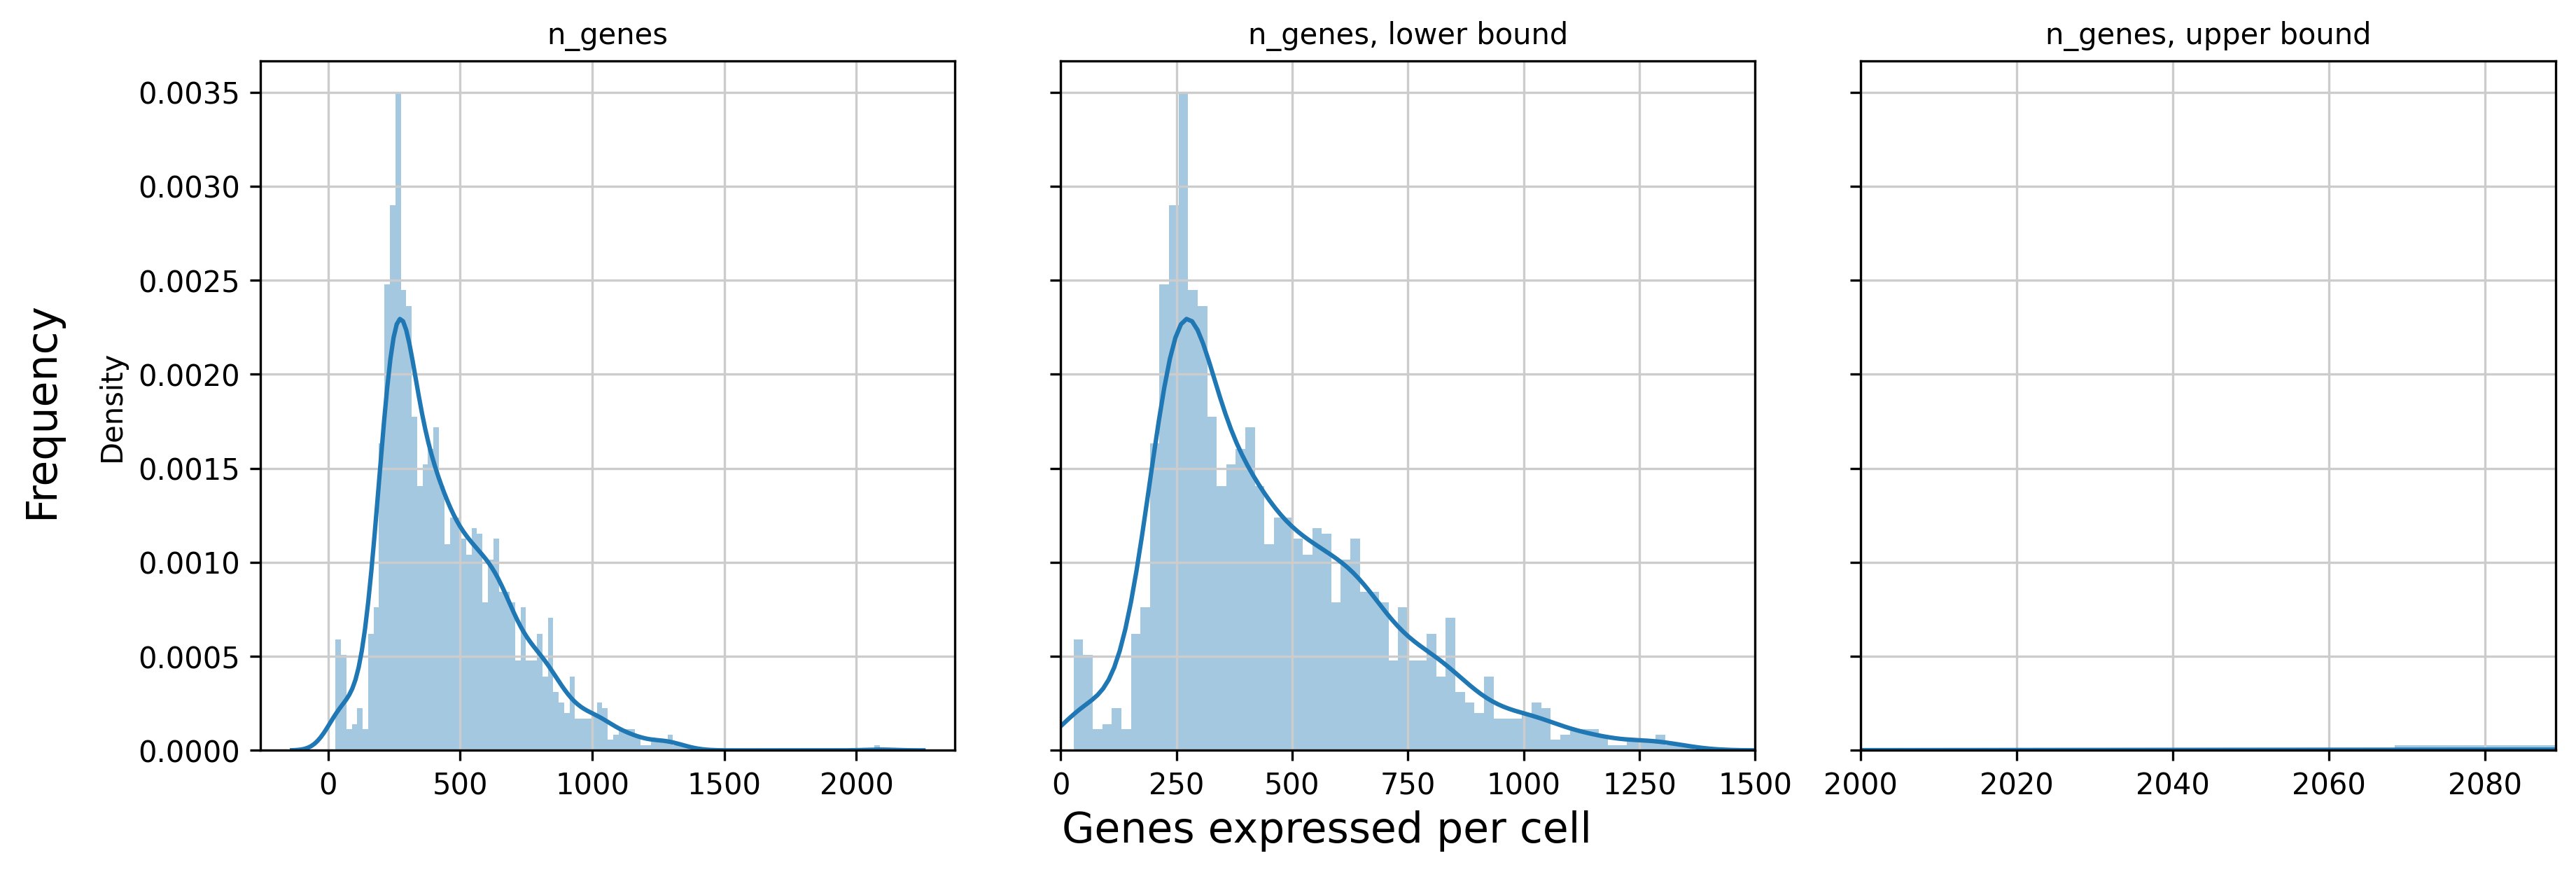

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['n_genes']
x_lowerbound = 1500
x_upperbound = 2000
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax3, norm_hist=True, bins=nbins)

ax2.set_xlim(0,x_lowerbound)
ax3.set_xlim(x_upperbound, adata.obs['n_genes'].max() )

for ax in (ax1,ax2,ax3): 
  ax.set_xlabel('')

ax1.title.set_text('n_genes')
ax2.title.set_text('n_genes, lower bound')
ax3.title.set_text('n_genes, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Genes expressed per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

/tmp/ipykernel_3404272/1055941436.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
/tmp/ipykernel_3404272/1055941436.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x, ax=ax2, norm_hist=True, bins=int(nbins/(x_lowerbound[1]-x_lowerbound[0])) )
/tmp/i

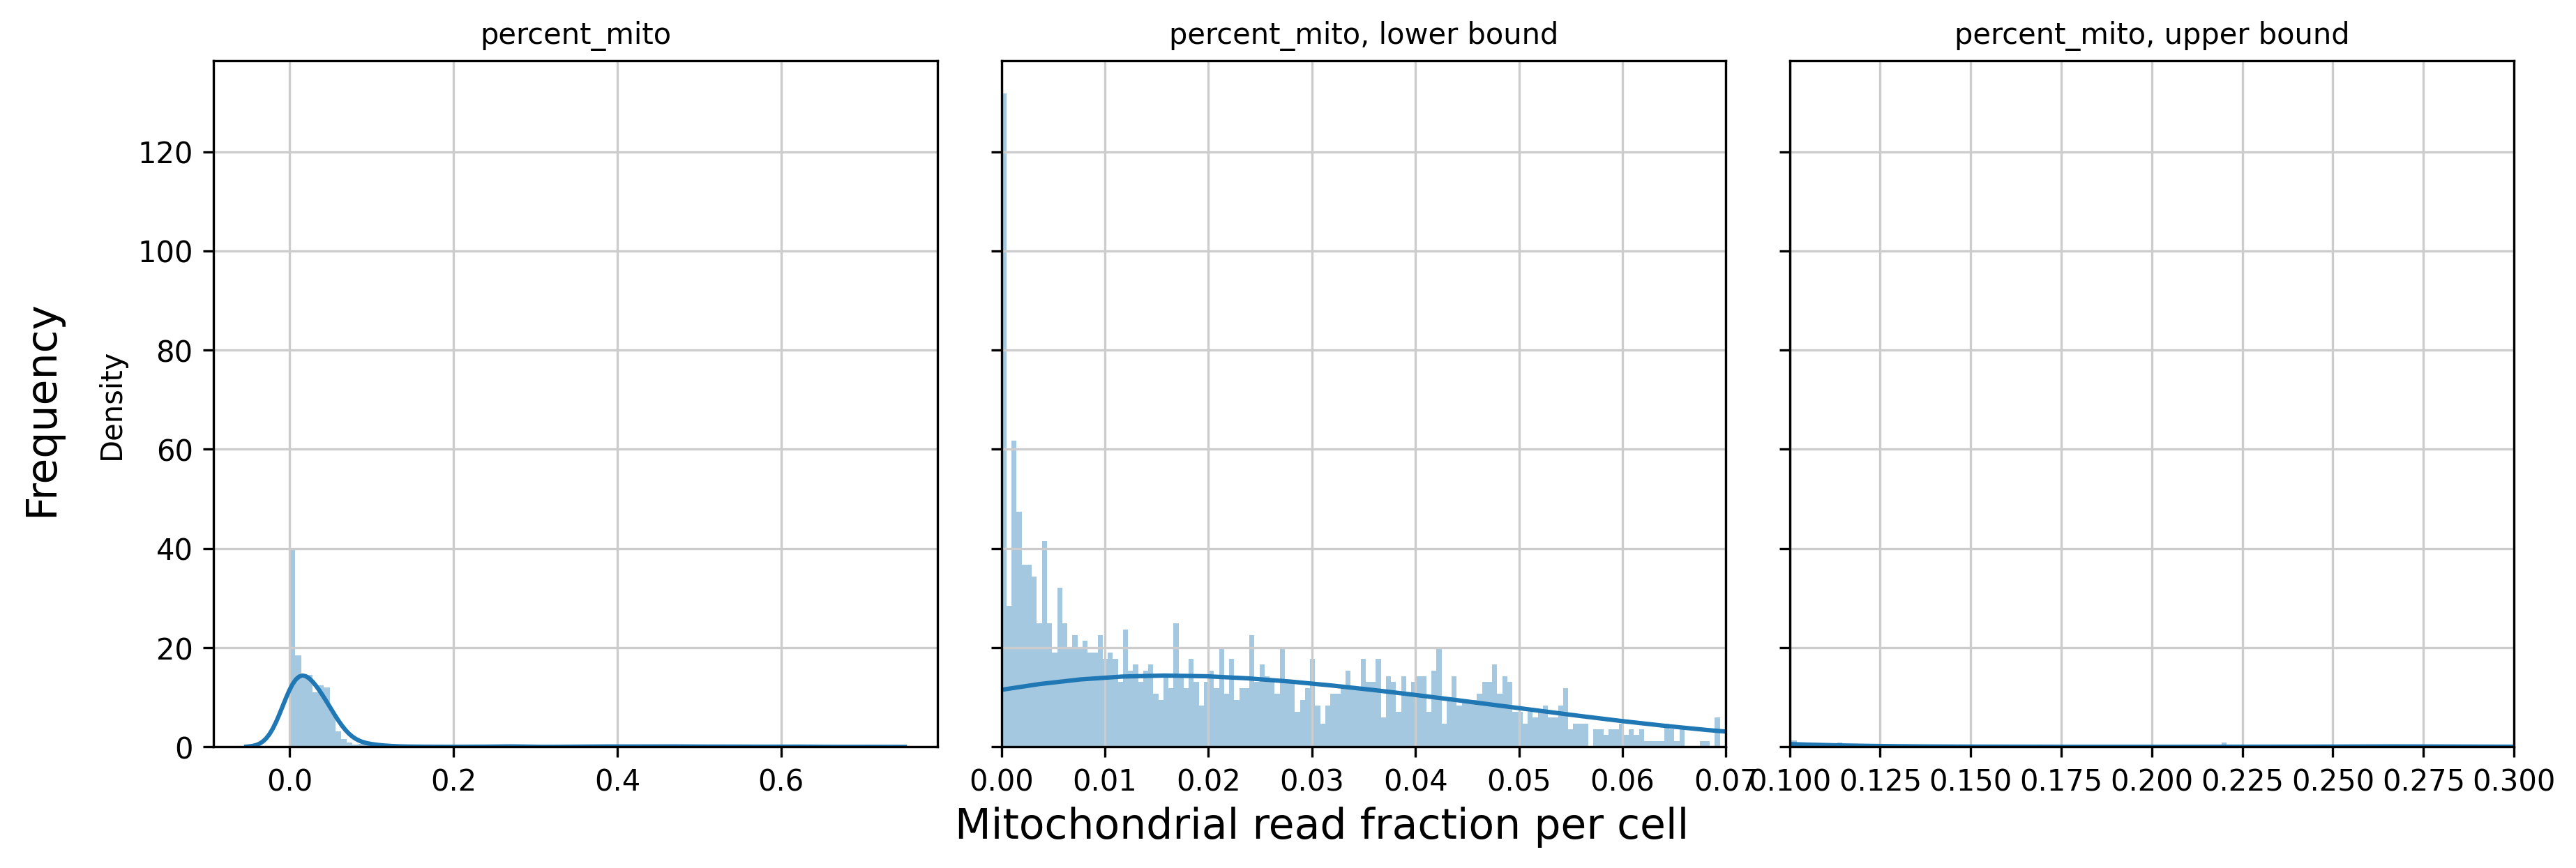

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['percent_mito']
x_lowerbound = [0.0, 0.07 ]
x_upperbound = [ 0.10, 0.3 ]
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=int(nbins/(x_lowerbound[1]-x_lowerbound[0])) )
sns.distplot(x, ax=ax3, norm_hist=True, bins=int(nbins/(x_upperbound[1]-x_upperbound[0])) )

ax2.set_xlim(x_lowerbound[0], x_lowerbound[1])
ax3.set_xlim(x_upperbound[0], x_upperbound[1] )
for ax in (ax1,ax2,ax3): 
  ax.set_xlabel('')

ax1.title.set_text('percent_mito')
ax2.title.set_text('percent_mito, lower bound')
ax3.title.set_text('percent_mito, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Mitochondrial read fraction per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

/tmp/ipykernel_3404272/3363066550.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
/tmp/ipykernel_3404272/3363066550.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
/tmp/ipyk

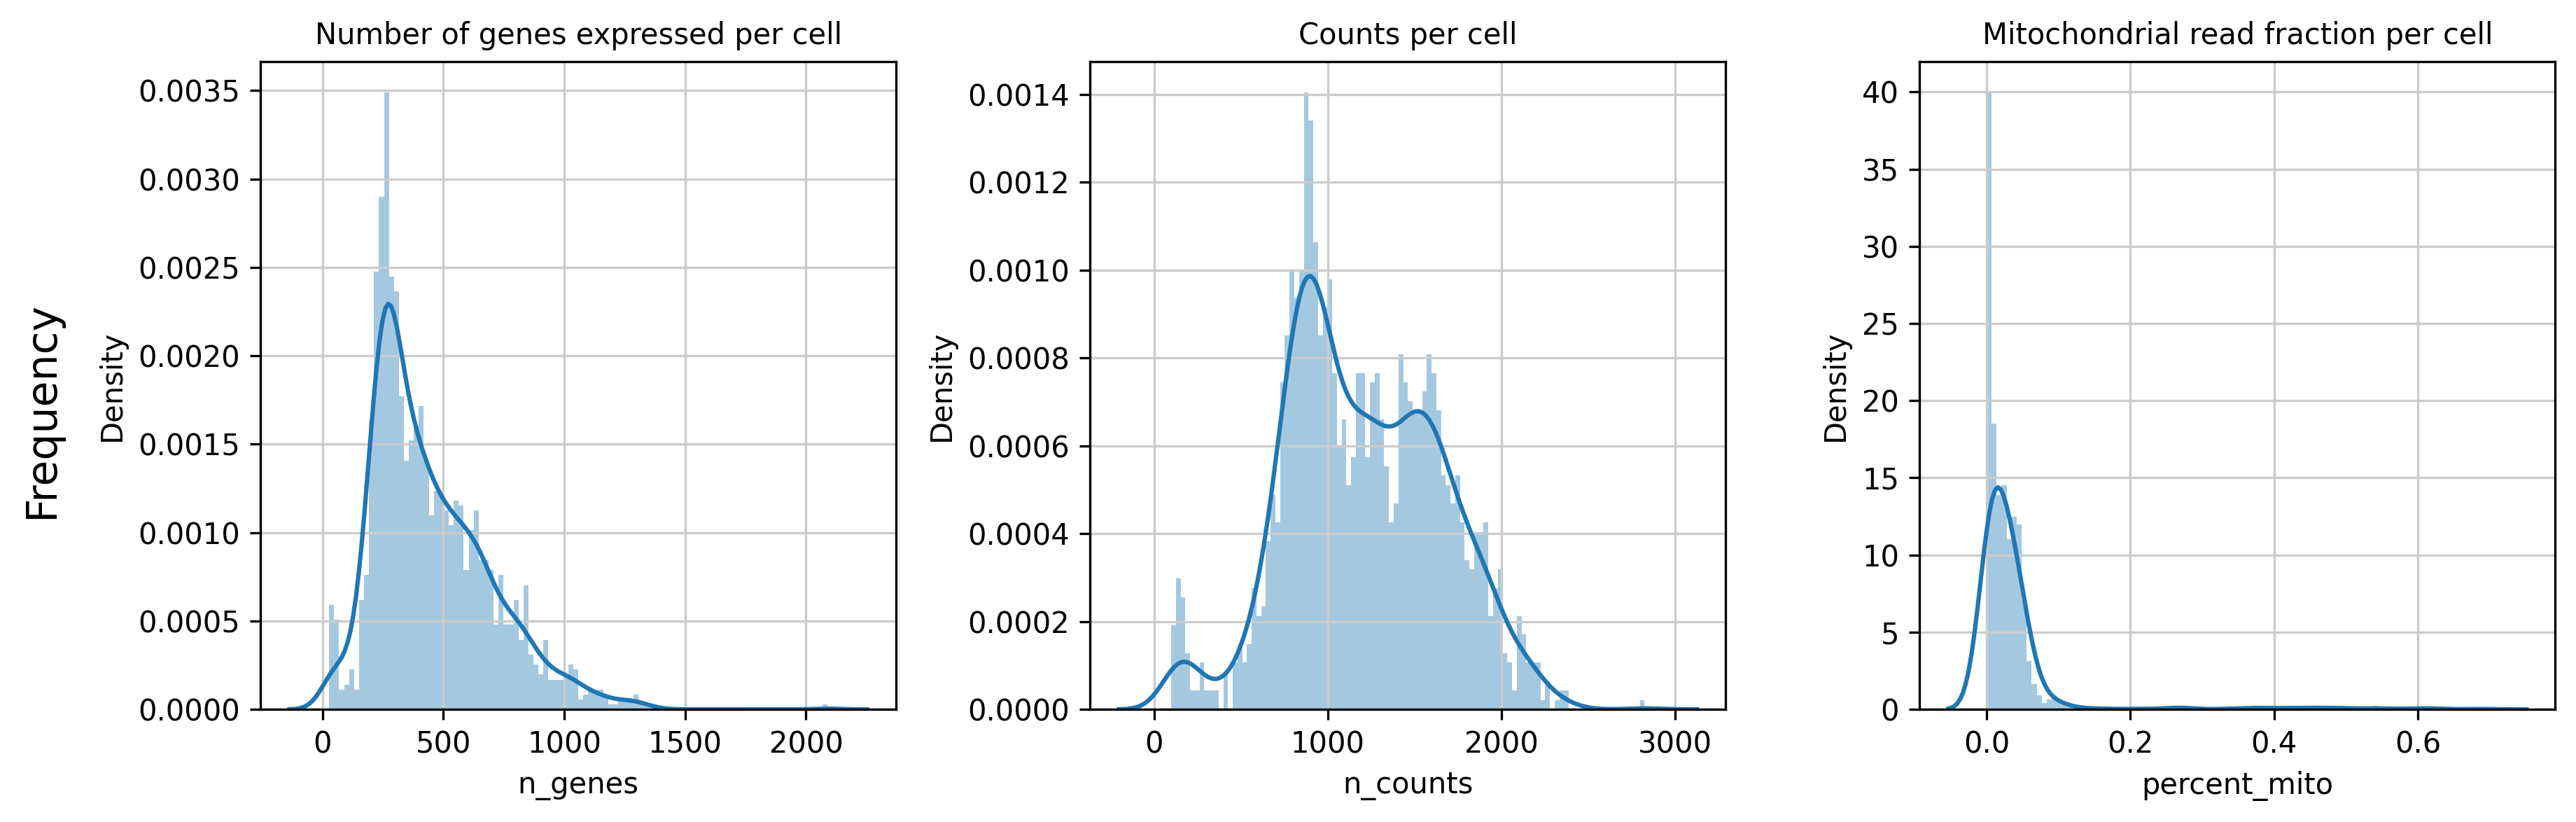

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
sns.distplot( adata.obs['percent_mito'], ax=ax3, norm_hist=True, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()

fig.savefig('filtering_panel_prefilter.pdf', dpi=600, bbox_inches='tight')

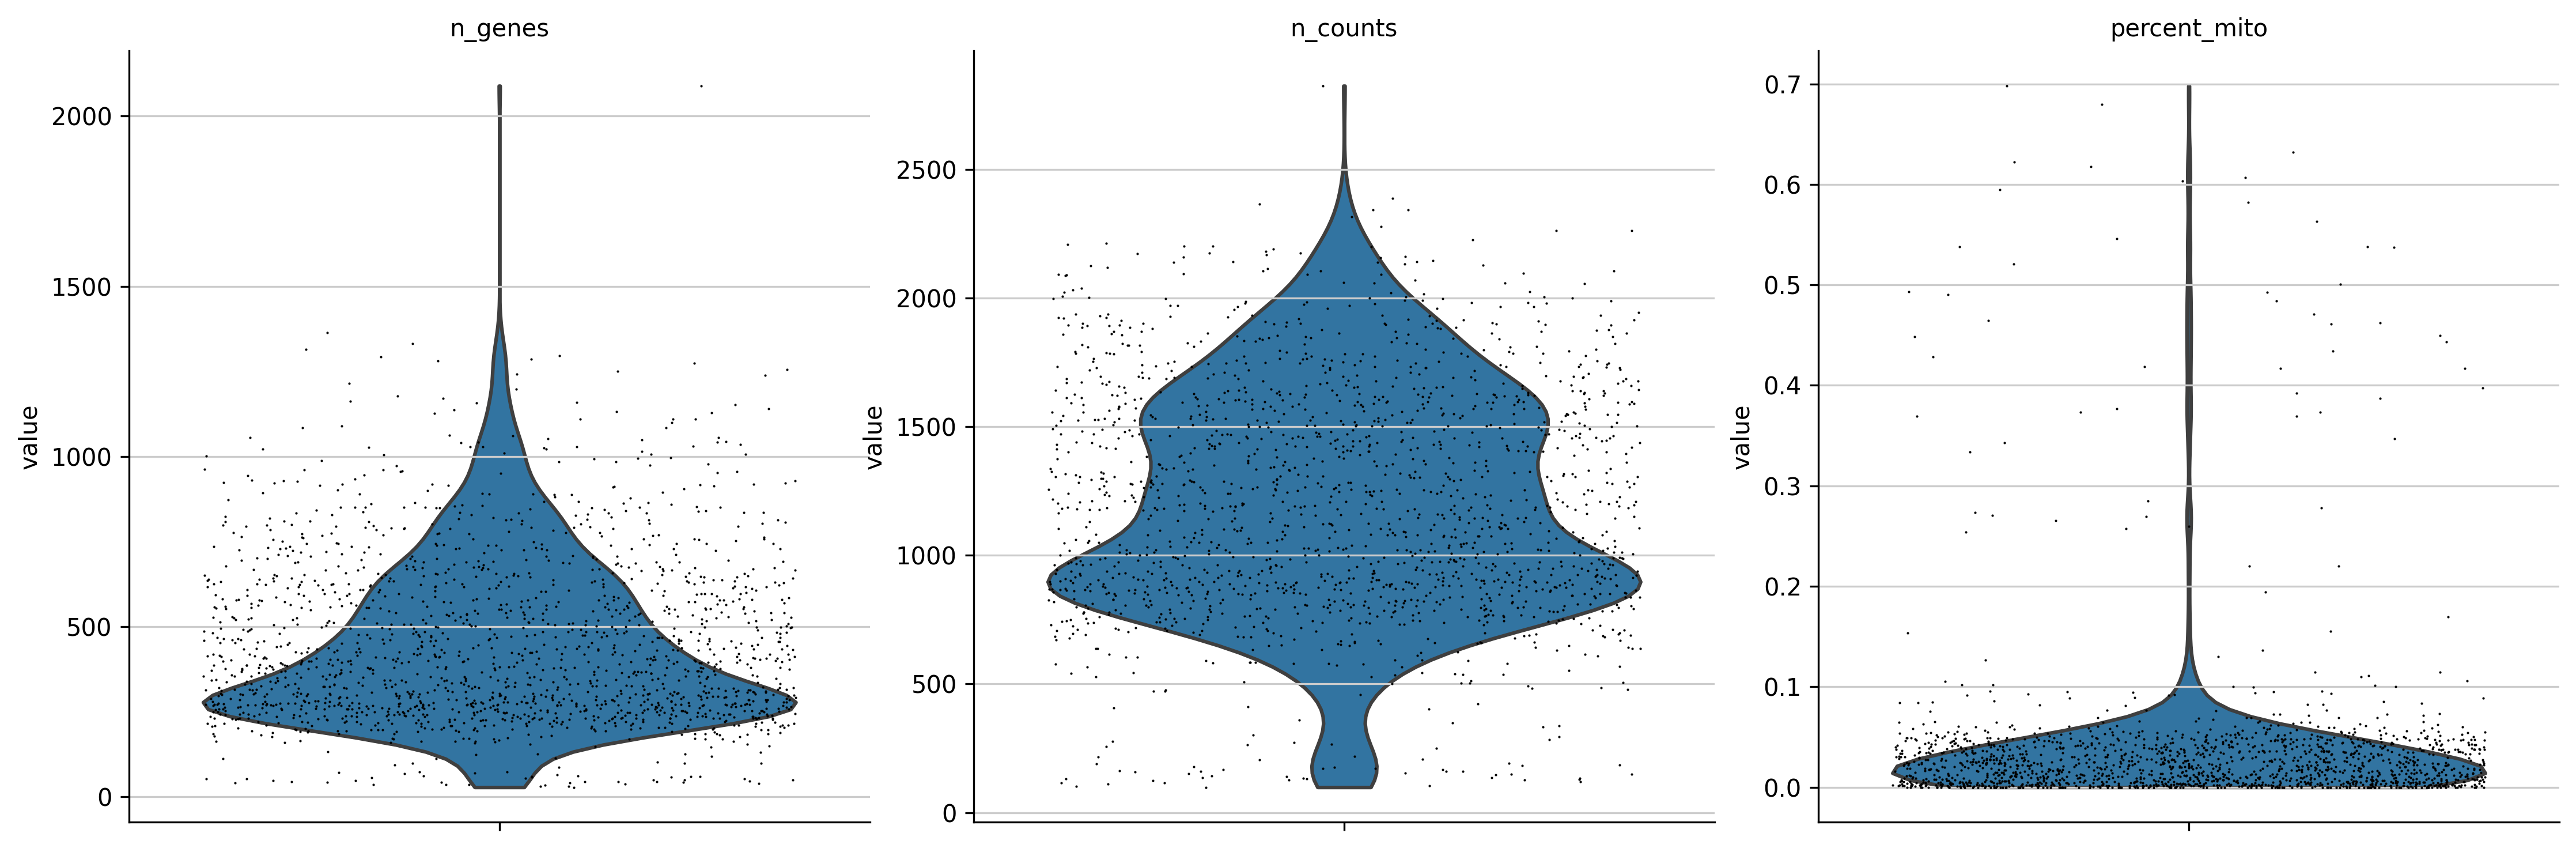

In [19]:

sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0.4, multi_panel=True )

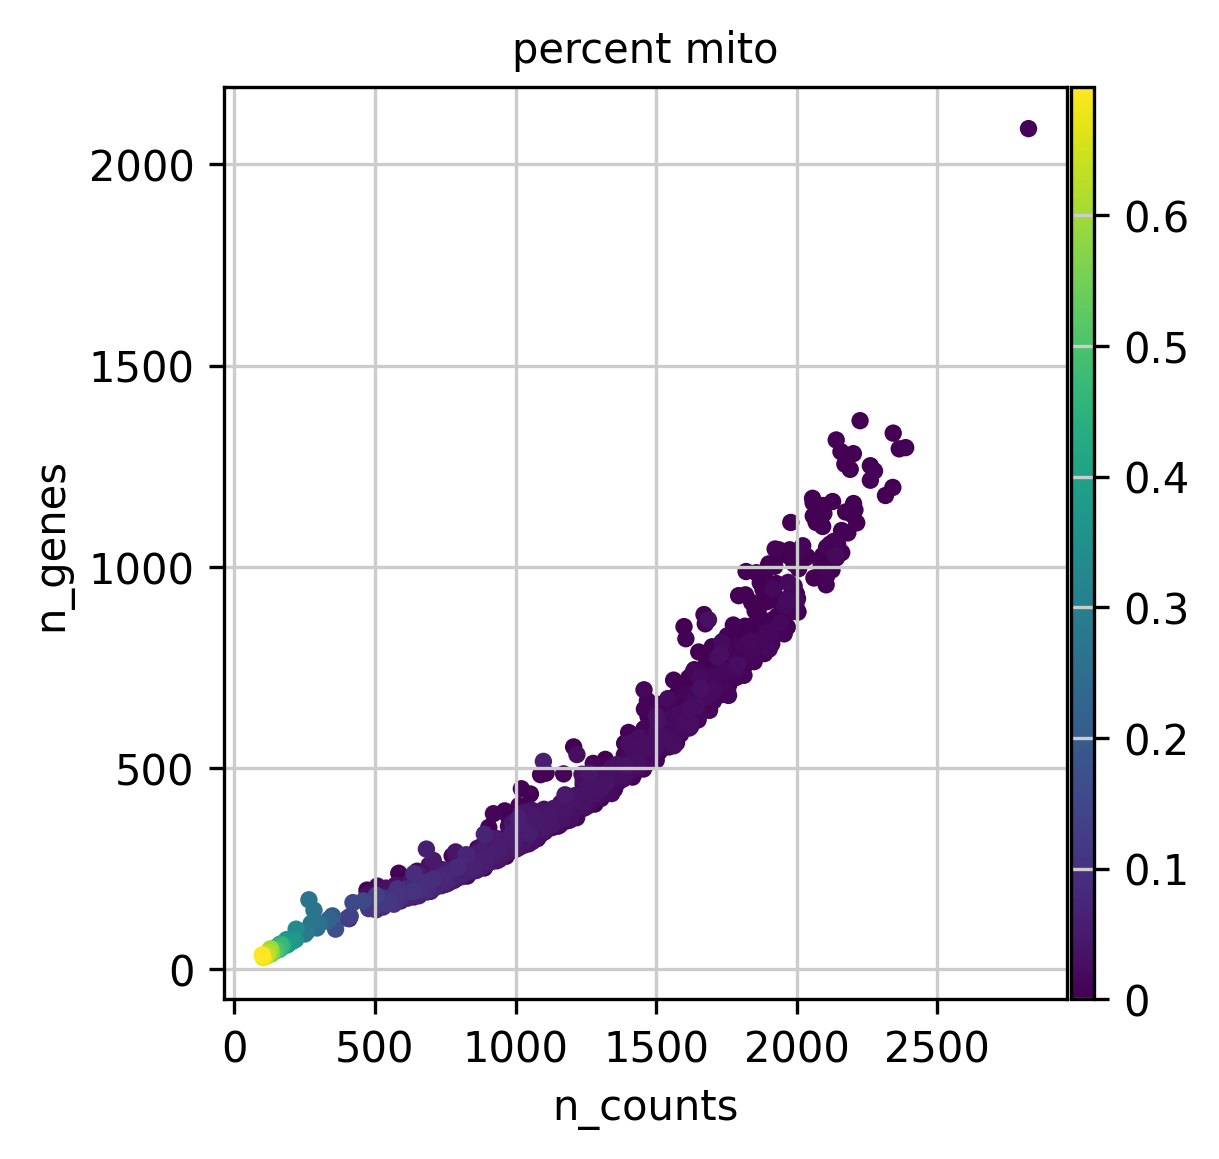

In [20]:

sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

In [21]:
# initial cuts
sc.pp.filter_cells(adata, min_genes=200 )
sc.pp.filter_genes(adata, min_cells=3 )

filtered out 131 cells that have less than 200 genes expressed
filtered out 7347 genes that are detected in less than 3 cells


In [22]:
adata = adata[adata.obs['n_genes'] < 4000, :]
adata = adata[adata.obs['percent_mito'] < 0.15, :]

/tmp/ipykernel_3404272/4135359199.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
/tmp/ipykernel_3404272/4135359199.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
/tmp/ipyk

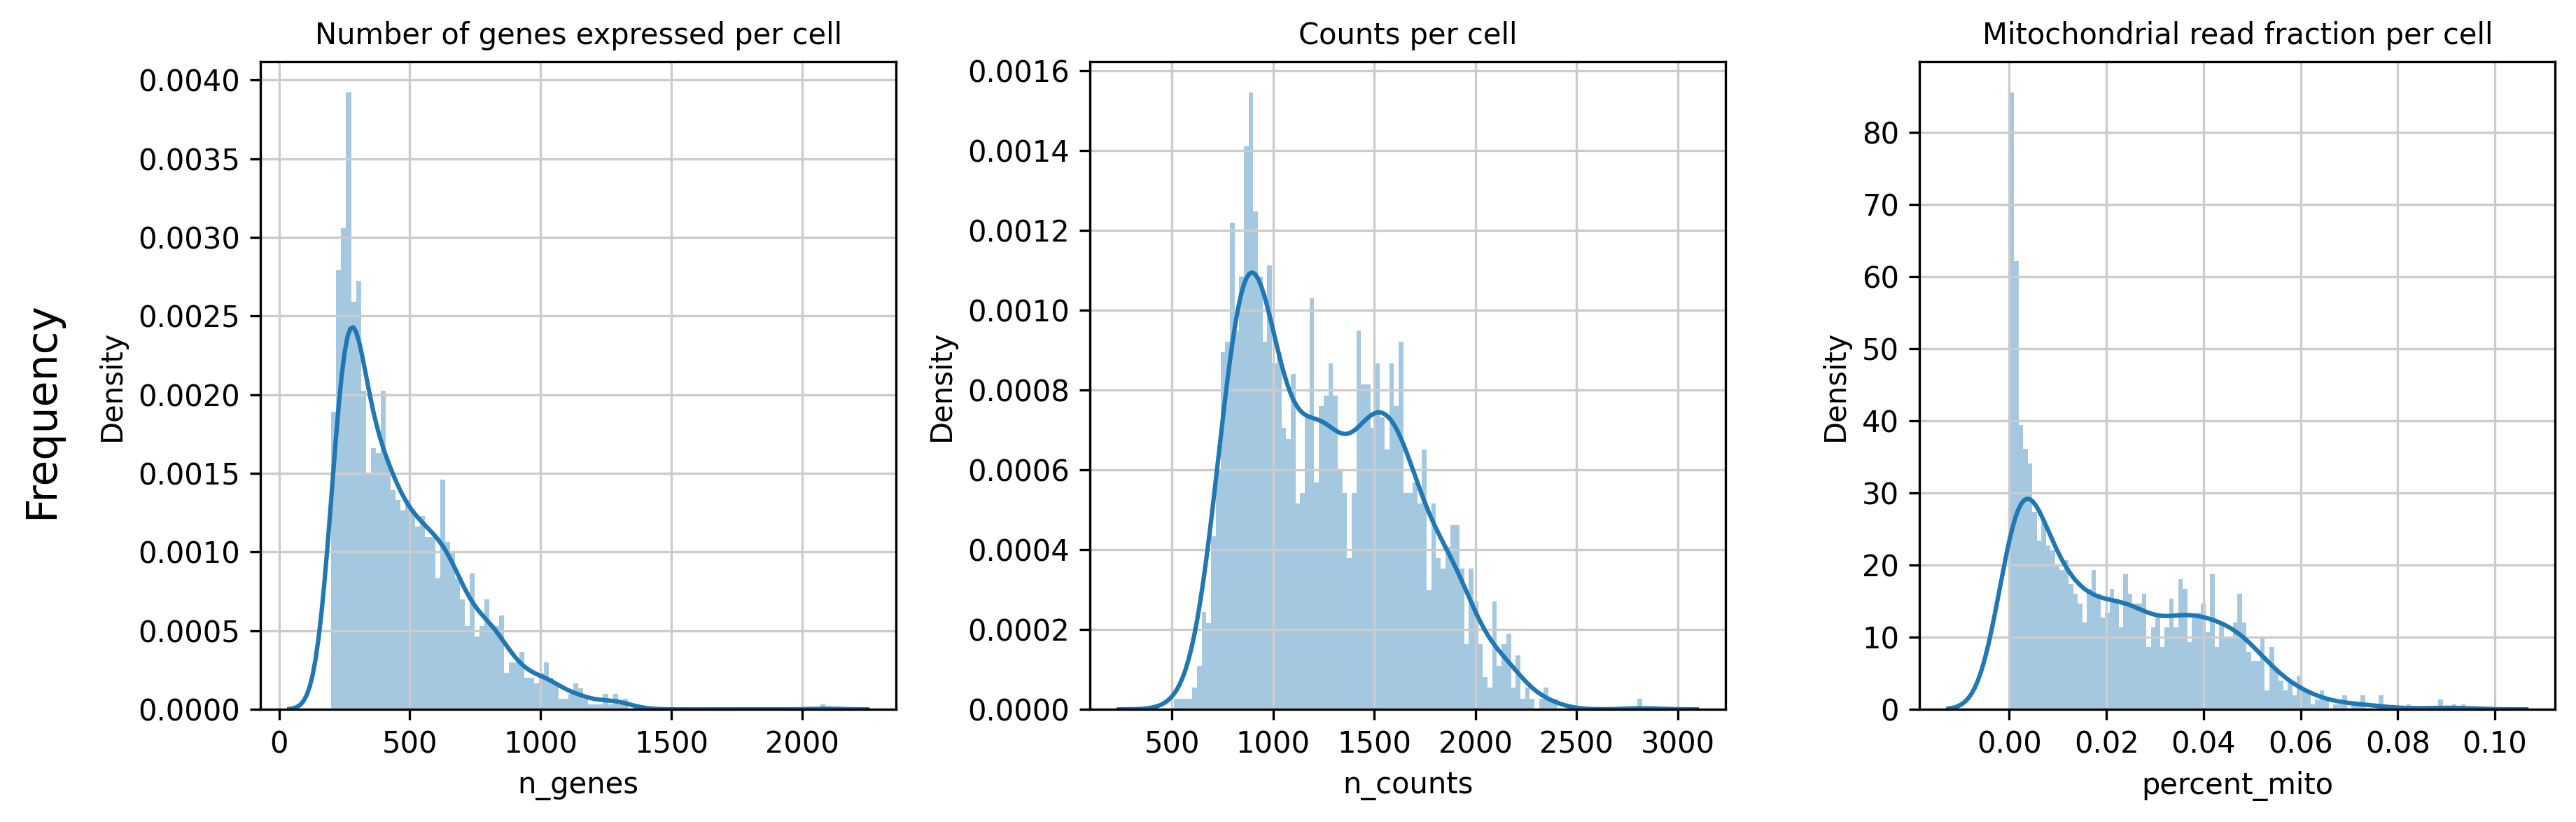

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

adata.obs['n_genes']

sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
sns.distplot( adata.obs['percent_mito'], ax=ax3, norm_hist=True, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()

fig.savefig('filtering_panel_postfilter.pdf', dpi=600, bbox_inches='tight')

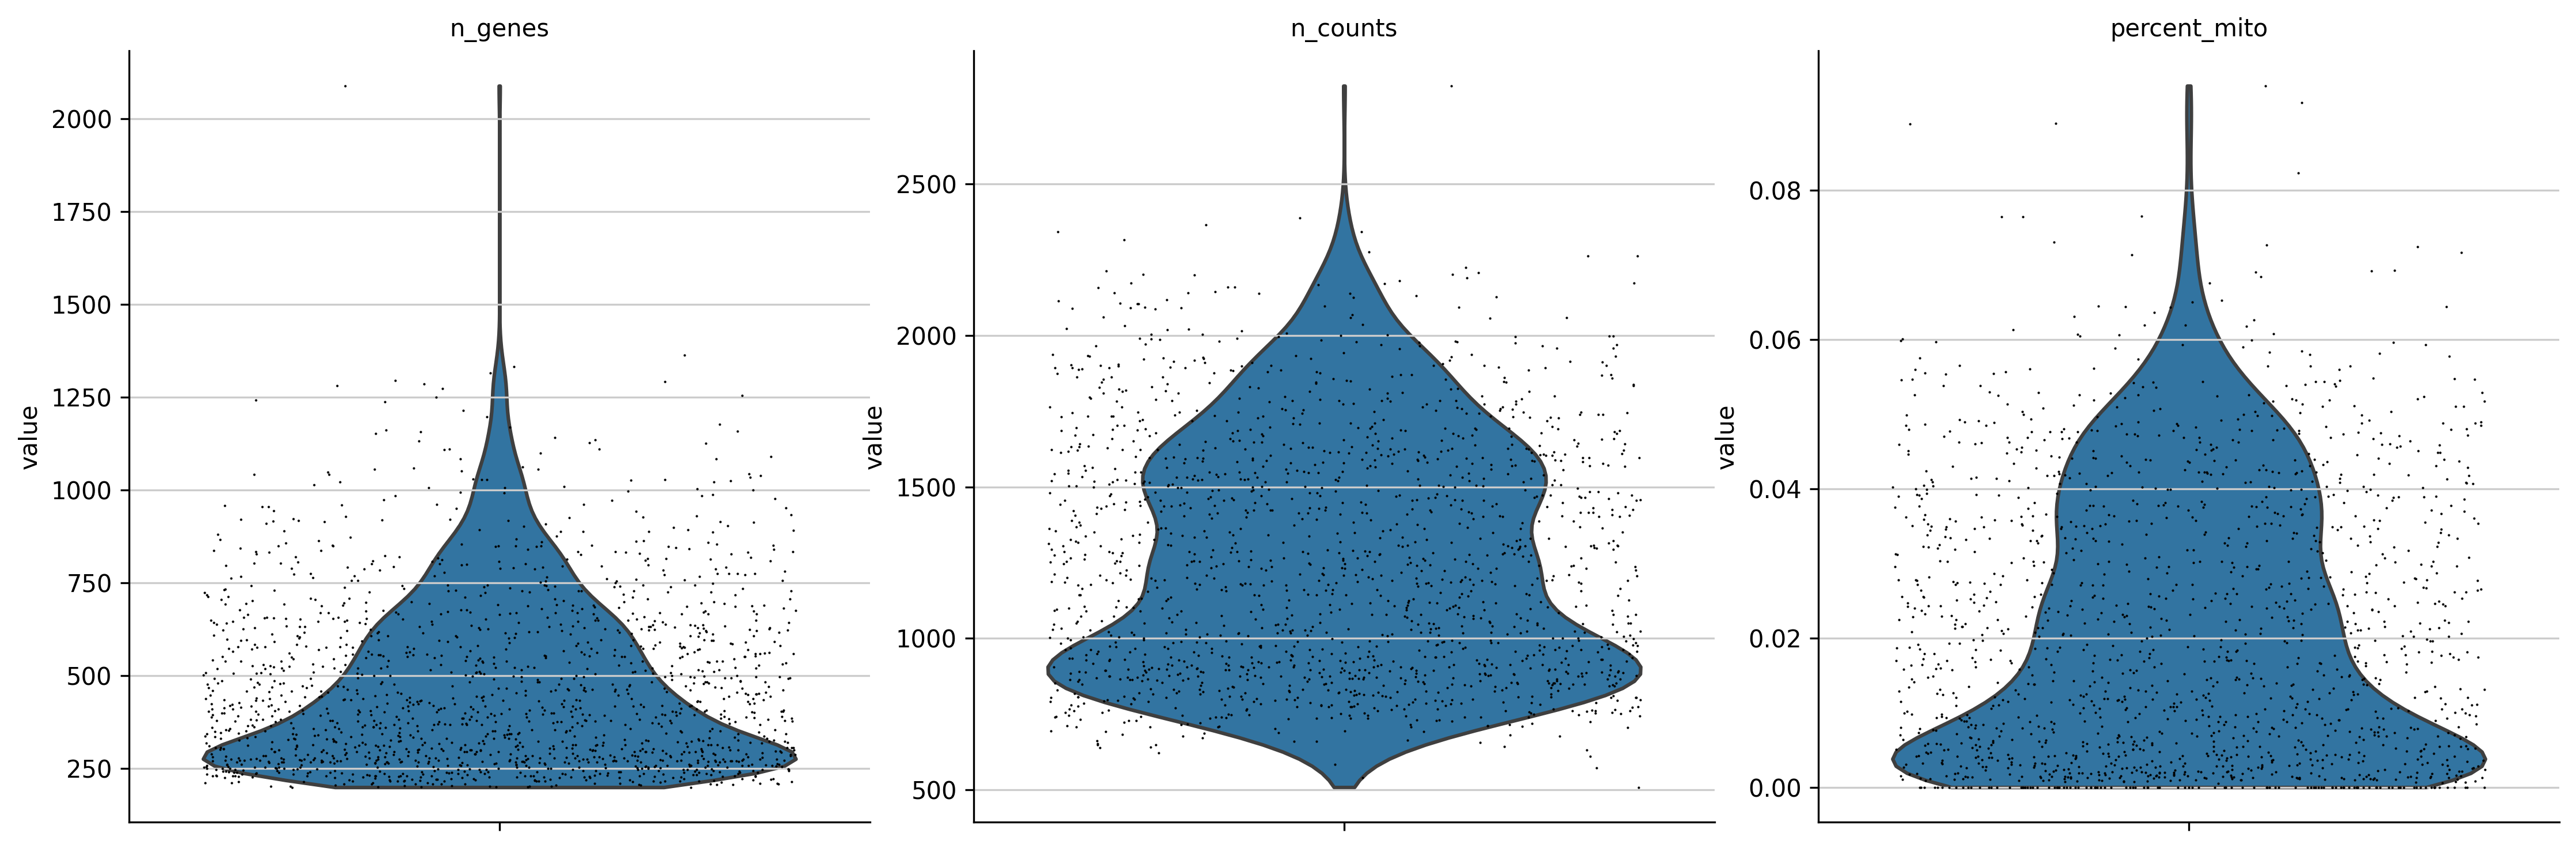

In [24]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0.4, multi_panel=True )

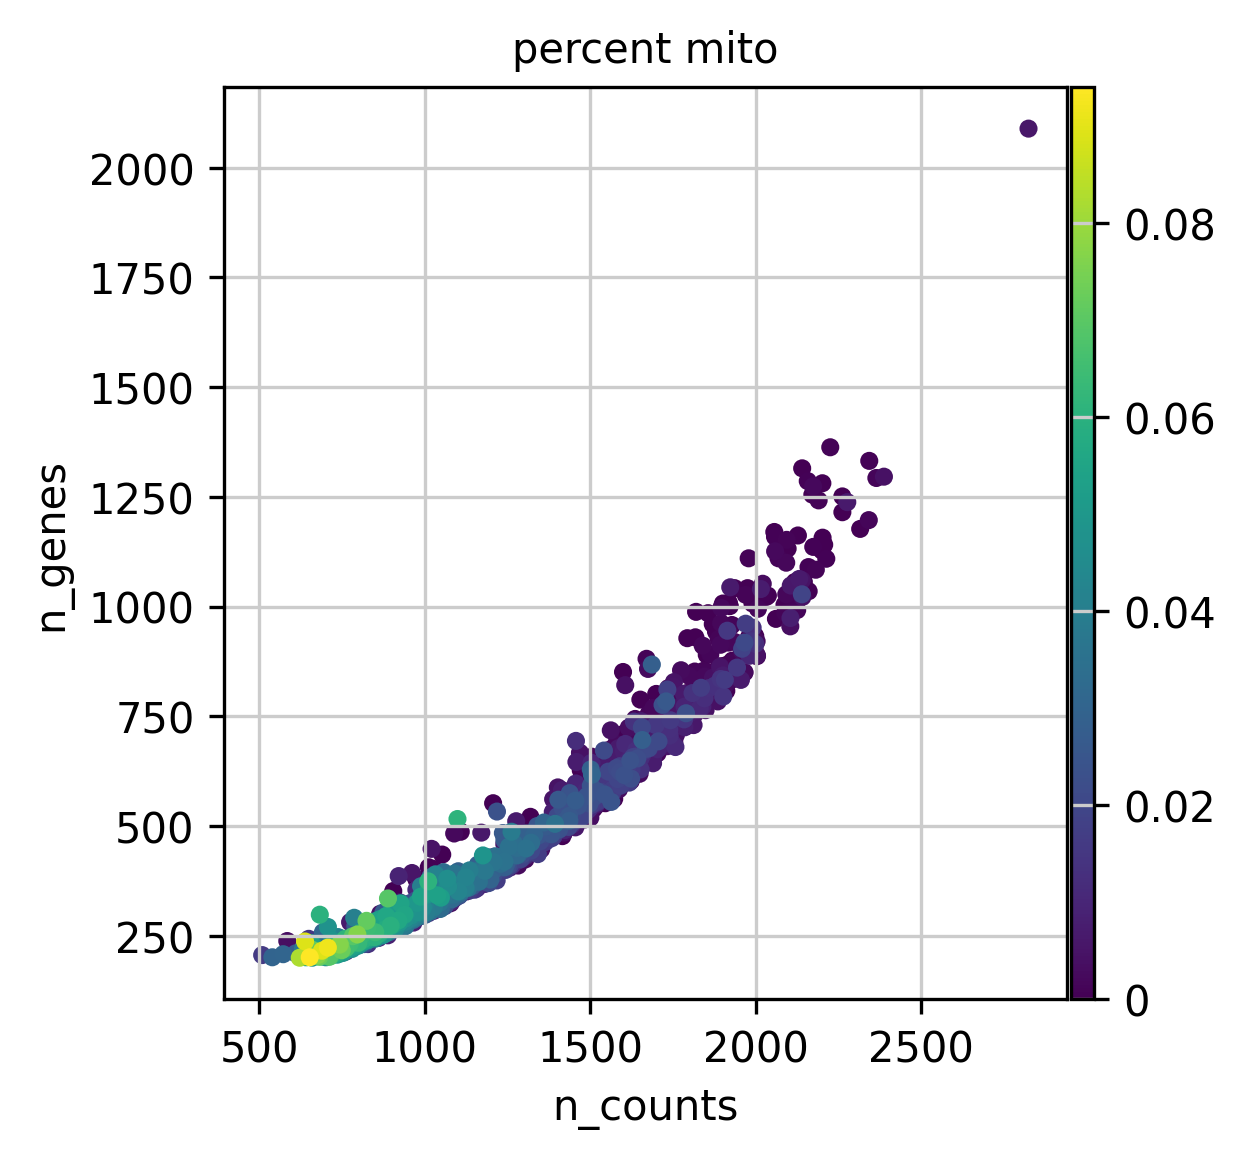

In [25]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')


In [26]:
adata.write( f_anndata_path )


In [27]:
adata

View of AnnData object with n_obs × n_vars = 1593 × 8726
    obs: 'doublet_scores', 'integrated_snn_res.0.1', 'integrated_snn_res.0.5', 'nCount_RNA', 'nFeature_RNA', 'nGene', 'nUMI', 'orig.ident', 'percent.mt', 'percent.rb', 'predicted_doublets', 'seurat_clusters', 'treatment', 'louvain', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'
    obsm: 'X_umap', 'X_pca'

In [28]:
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}
lp.create( f_loom_path_scenic, adata.X.transpose(), row_attrs, col_attrs)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


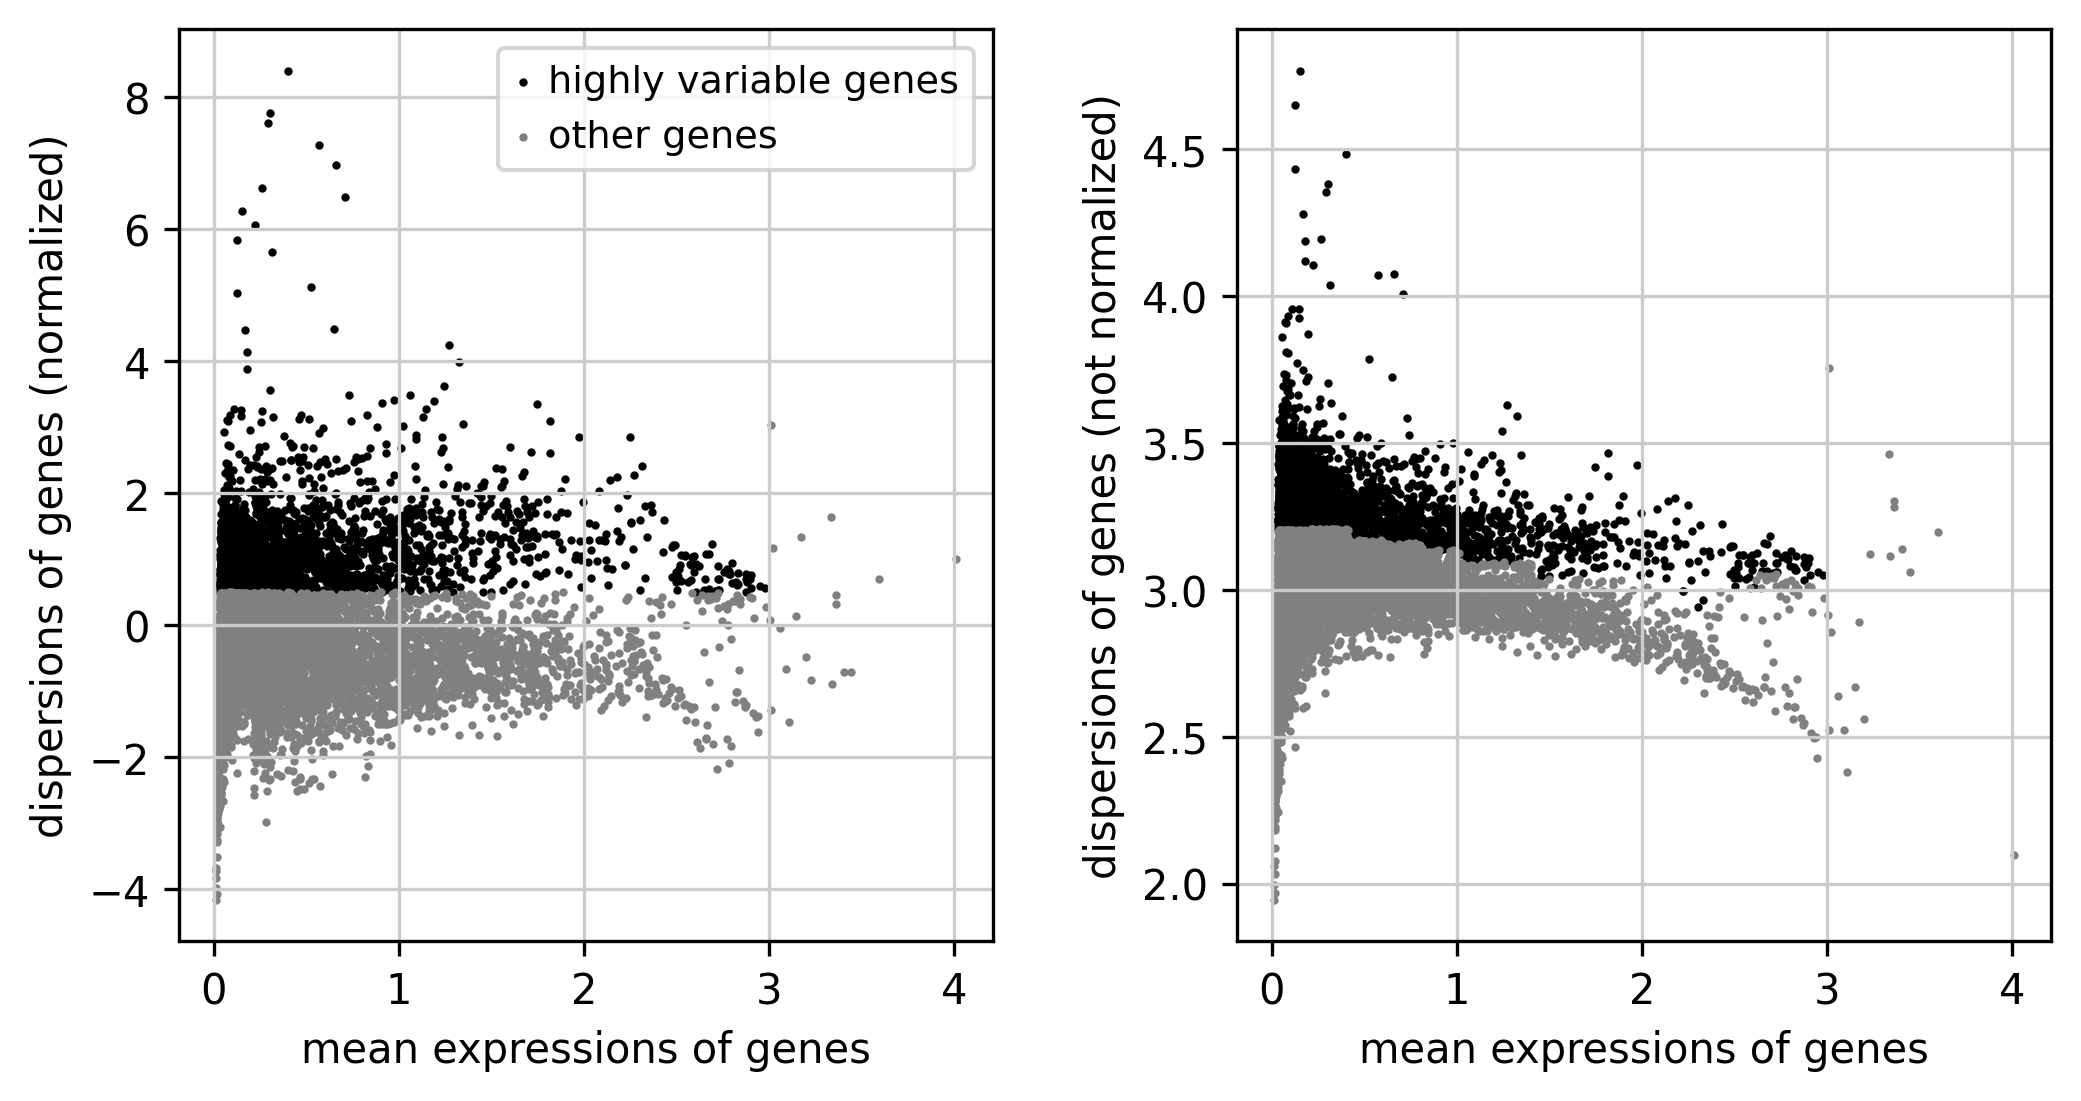

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:06)


In [29]:
# save a copy of the raw data
adata.raw = adata

# Total-count normalize (library-size correct) to 10,000 reads/cell
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# log transform the data.
sc.pp.log1p(adata)

# identify highly variable genes.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# keep only highly variable genes:
adata = adata[:, adata.var['highly_variable']]

# regress out total counts per cell and the percentage of mitochondrial genes expressed
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'] ) #, n_jobs=args.threads)

# scale each gene to unit variance, clip values exceeding SD 10.
sc.pp.scale(adata, max_value=10)

# update the anndata file:
adata.write( f_anndata_path )

In [30]:
adata.obs

,doublet_scores,integrated_snn_res.0.1,integrated_snn_res.0.5,nCount_RNA,nFeature_RNA,nGene,nUMI,orig.ident,percent.mt,percent.rb,predicted_doublets,seurat_clusters,treatment,louvain,n_genes,percent_mito,n_counts
CellID,,,,,,,,,,,,,,,,,
AAACCCAGTCGAAACG-1_3,0.054557,2,13,637.0,336,336,637.0,P251L1merged,0.0,0.0,0,2,P251L,2,336,0.037155,1023.666443
AAACCCATCATGCGGC-1_3,0.032701,3,13,1052.0,483,483,1052.0,P251L1merged,0.0,0.0,0,3,P251L,3,483,0.026097,1292.459595
AAACCCATCGGCATTA-1_3,0.047150,3,13,501.0,236,236,501.0,P251L1merged,0.0,0.0,0,3,P251L,3,236,0.051865,796.604858
AAACGAAAGCCTATTG-1_3,0.082252,3,13,558.0,279,279,558.0,P251L1merged,0.0,0.0,0,3,P251L,3,279,0.036596,915.572998
AAAGAACGTAGACAAT-1_3,0.082252,1,13,1087.0,626,626,1087.0,P251L1merged,0.0,0.0,0,1,P251L,1,626,0.011986,1620.670532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTGATGGTGTGGACA-1_6,0.108323,3,13,575.0,309,309,575.0,LIB055588_CRN00233457,0.0,0.0,0,3,P251L,3,309,0.041559,985.647095
TTCCGTGGTGTCGCTG-1_6,0.037592,2,13,559.0,351,351,559.0,LIB055588_CRN00233457,0.0,0.0,0,2,P251L,2,351,0.042232,1092.196533
TTCTCTCTCGCGCTGA-1_6,0.062928,2,13,1280.0,480,480,1280.0,LIB055588_CRN00233457,0.0,0.0,0,2,P251L,2,480,0.009365,1268.176514


In [31]:
# tSNE
tsne = TSNE( n_jobs=20 )
adata.obsm['X_tsne'] = tsne.fit_transform( adata.X )
adata.write( f_anndata_path )


In [32]:
cluster_id = adata.obs["seurat_clusters"]

In [33]:
cluster_id = pd.Series(cluster_id,dtype="category")

In [34]:
cluster_id

CellID
AAACCCAGTCGAAACG-1_3    2
AAACCCATCATGCGGC-1_3    3
AAACCCATCGGCATTA-1_3    3
AAACGAAAGCCTATTG-1_3    3
AAAGAACGTAGACAAT-1_3    1
                       ..
TGTGATGGTGTGGACA-1_6    3
TTCCGTGGTGTCGCTG-1_6    2
TTCTCTCTCGCGCTGA-1_6    2
TTCTGTATCATCGTAG-1_6    2
TTGGGTATCAGTAGGG-1_6    2
Name: seurat_clusters, Length: 1593, dtype: category
Categories (4, uint64): [1, 2, 3, 4]

In [90]:
# transcription factors list
f_tfs = "/mnt/data0/projects/biohub/hassan2022/output/SCENIC/pyscenic_workflow/tf_list/allTFs_dmel.txt" # human
# f_tfs = "/ddn1/vol1/staging/leuven/stg_00002/lcb/cflerin/resources/allTFs_dmel.txt" # drosophila
# f_tfs = "/ddn1/vol1/staging/leuven/stg_00002/lcb/cflerin/resources/allTFs_mm.txt"   # mouse
# tf_names = load_tf_names( f_tfs )

In [ ]:
# run pyscenic bash script 

In [35]:
# read in adjacency matrix 
adjacencies = pd.read_csv("/mnt/data0/projects/biohub/hassan2022/output/SCENIC/pyscenic_workflow/MBON/output/TauKI/mutant_adj.csv", index_col=False)


In [36]:
adjacencies.head()

,TF,target,importance
0,RpS4,RpL6,109.634898
1,RpS4,eEF1gamma,106.636012
2,RpS4,CG12116,102.870085
3,RpS4,RpL26,97.533546
4,RpS4,RpL10,97.388477


In [37]:
nGenesDetectedPerCellbefore = np.sum(adata.X>0, axis=1)
nGenesDetectedPerCell = pd.DataFrame(nGenesDetectedPerCellbefore)
percentiles = nGenesDetectedPerCell.quantile([0.01, 0.05, 0.10, 0.50, 1])
print(percentiles)

           0
0.01   55.84
0.05   71.00
0.10   84.00
0.50  149.00
1.00  999.00


/tmp/ipykernel_3404272/897791332.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')


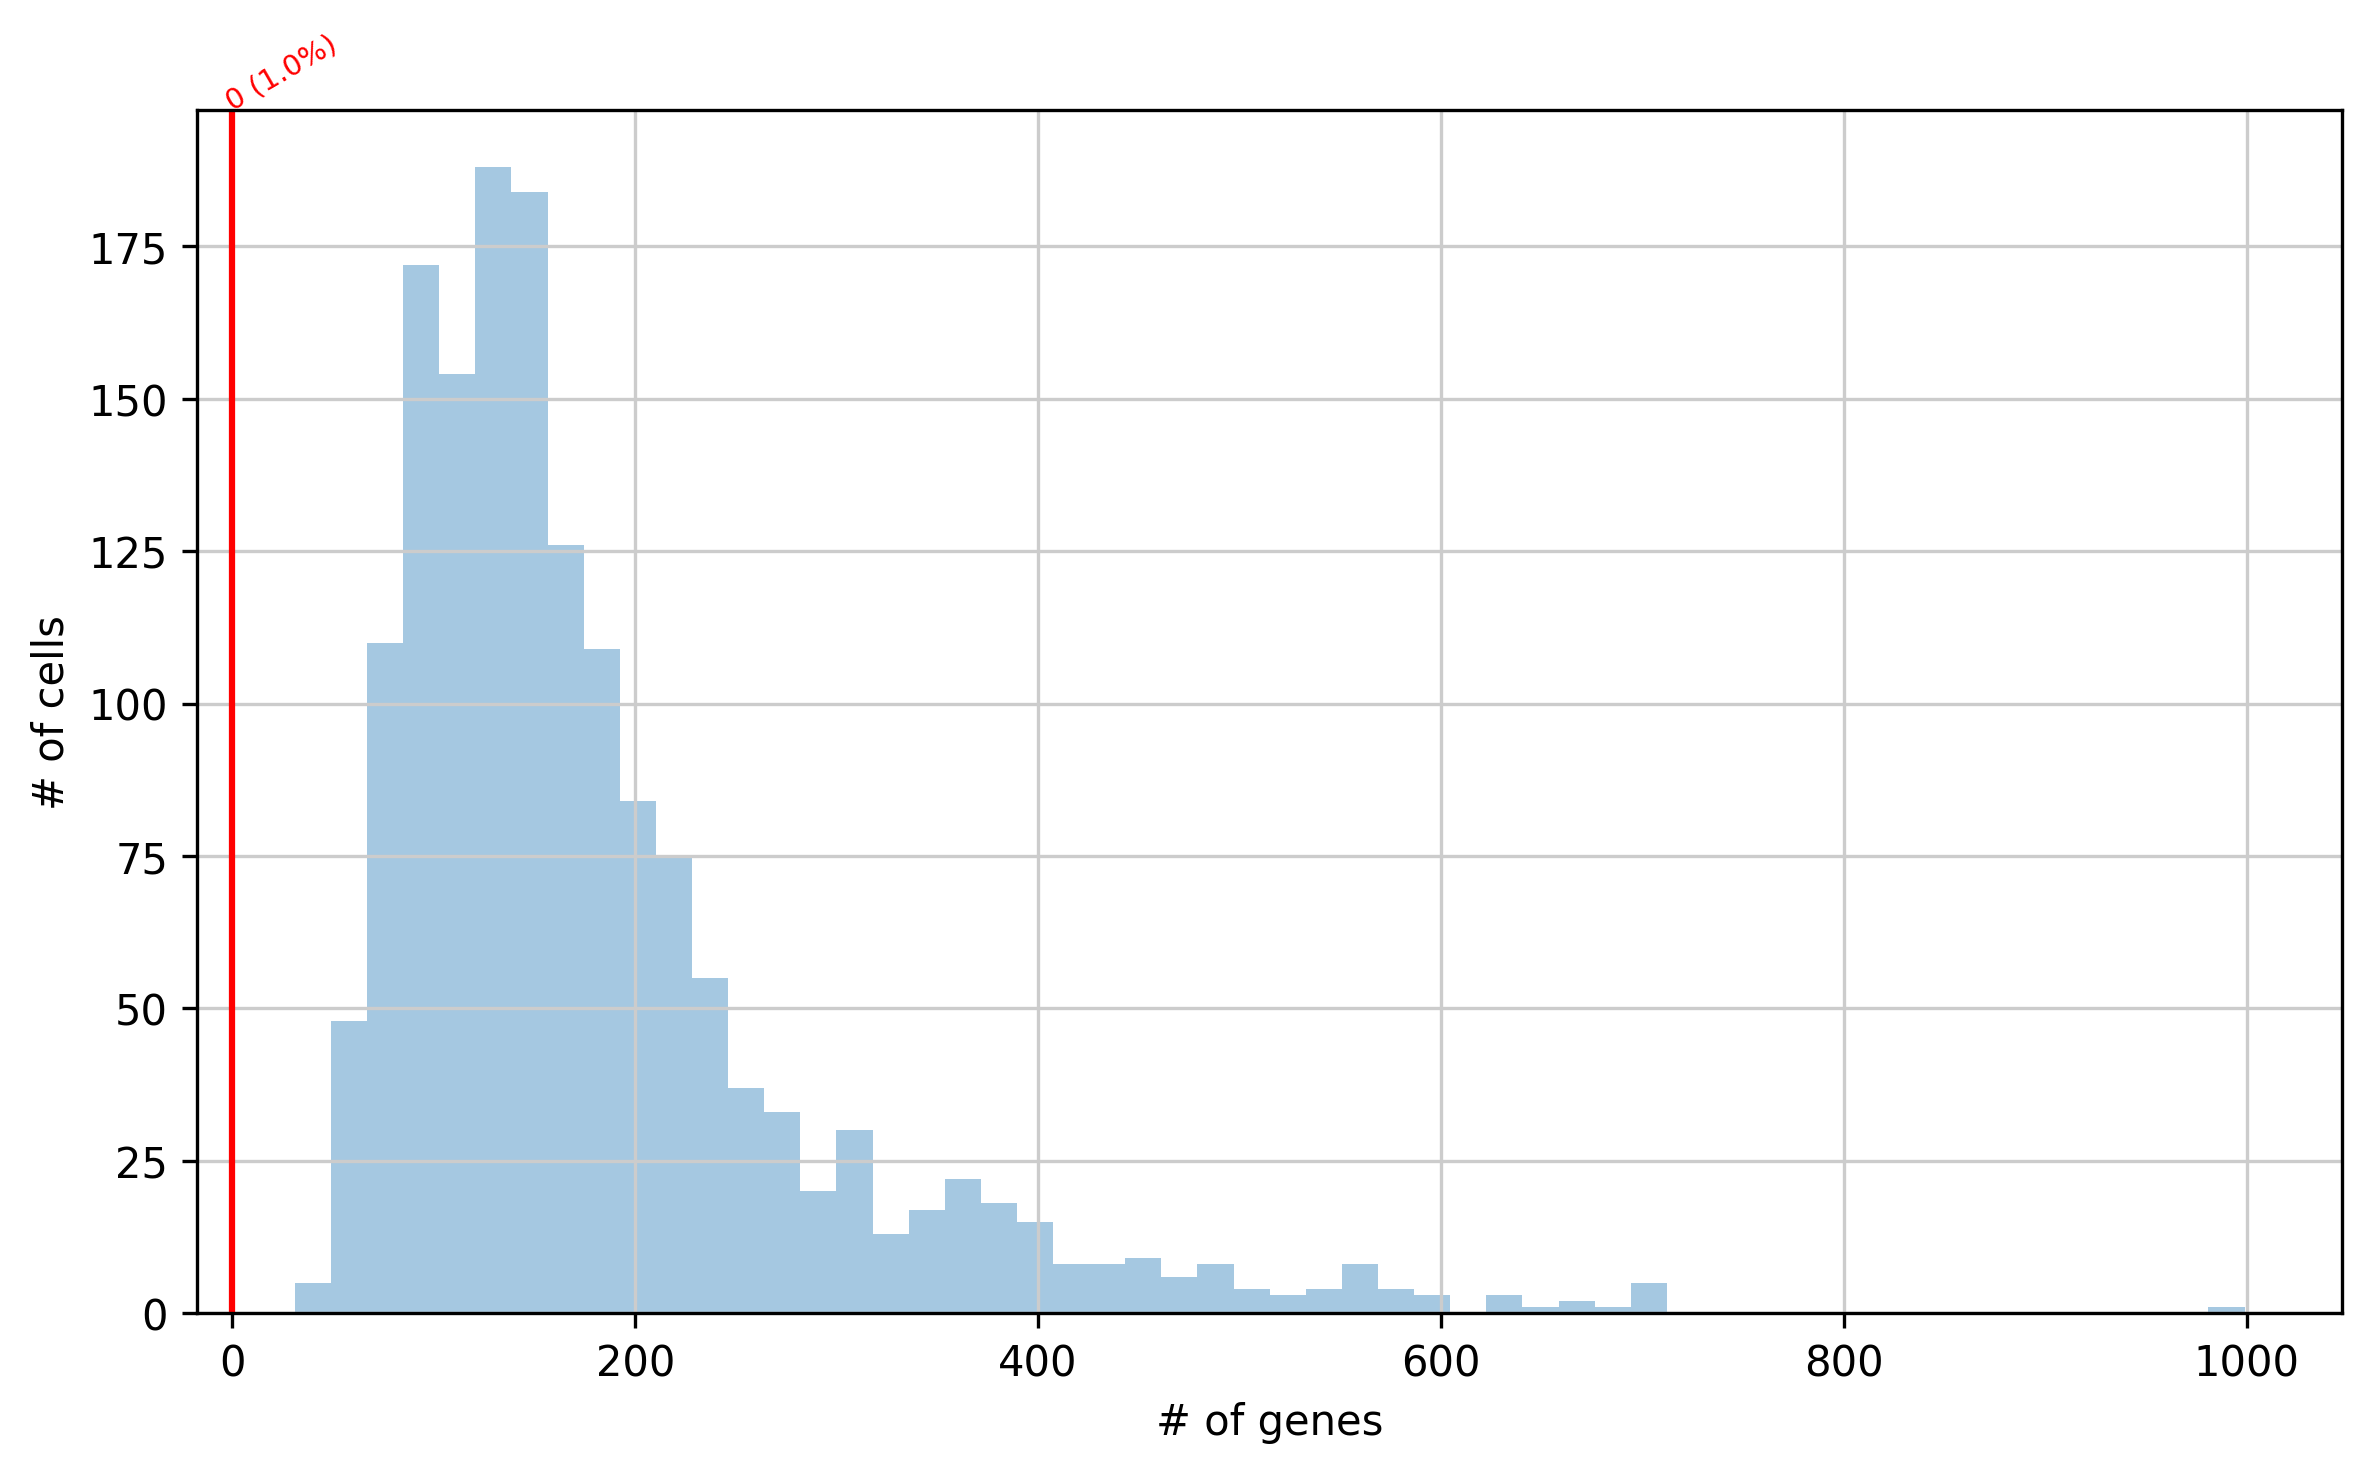

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0,ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({percentiles.index.values[i]*100}%)', color='red', rotation=30, size='x-small',rotation_mode='anchor' )
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

In [39]:
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [40]:
import umap

# UMAP
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
dr_umap = runUmap( auc_mtx )
pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_umap.txt", sep='\t')
# tSNE
tsne = TSNE( n_jobs=20 )
dr_tsne = tsne.fit_transform( auc_mtx )
pd.DataFrame(dr_tsne, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_tsne.txt", sep='\t')

/home/acicalo/miniconda3/envs/pyscenic/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/acicalo/miniconda3/envs/pyscenic/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/acicalo/miniconda3/envs/pyscenic/lib/python3.10/site-pac

In [41]:
# scenic output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
#exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID)
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
regulons = lf.ra.Regulons
dr_umap = pd.read_csv( 'scenic_umap.txt', sep='\t', header=0, index_col=0 )
dr_tsne = pd.read_csv( 'scenic_tsne.txt', sep='\t', header=0, index_col=0 )
###

In [42]:
auc_mtx.columns = auc_mtx.columns.str.replace('\(','_(')
regulons.dtype.names = tuple( [ x.replace("(","_(") for x in regulons.dtype.names ] )
# regulon thresholds
rt = meta['regulonThresholds']
for i,x in enumerate(rt):
    tmp = x.get('regulon').replace("(","_(")
    x.update( {'regulon': tmp} )

/tmp/ipykernel_3404272/1306291957.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  auc_mtx.columns = auc_mtx.columns.str.replace('\(','_(')


In [43]:
tsneDF = pd.DataFrame(adata.obsm['X_tsne'], columns=['_X', '_Y'])

Embeddings_X = pd.DataFrame( index=lf.ca.CellID )
Embeddings_X = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[0] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[0] ,
        dr_tsne['X'] ,
        dr_umap['X']
    ], sort=False, axis=1, join='outer' )
Embeddings_X.columns = ['1','2','3','4']

Embeddings_Y = pd.DataFrame( index=lf.ca.CellID )
Embeddings_Y = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[1] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[1] ,
        dr_tsne['Y'] ,
        dr_umap['Y']
    ], sort=False, axis=1, join='outer' )
Embeddings_Y.columns = ['1','2','3','4']

In [39]:
cellid = lf.ca.CellID
cellid = np.asarray(cellid)
pd.DataFrame(cellid).to_csv('/mnt/data0/projects/biohub/hassan2022/output/SCENIC/pyscenic_workflow/MBON/garnett/mutant_cellid.csv')

In [44]:
garnett = pd.read_csv( '/mnt/data0/projects/biohub/hassan2022/output/SCENIC/pyscenic_workflow/MBON/garnett/MBON_P251L_garnett_results.csv', index_col=0)
garnett.head()
garnett["cell_type"]

1       MBON
2       MBON
3       MBON
4       MBON
5       MBON
        ... 
1589    MBON
1590    MBON
1591    MBON
1592    MBON
1593    MBON
Name: cell_type, Length: 1593, dtype: object

In [45]:
### metadata
metaJson = {}

metaJson['embeddings'] = [
    {
        "id": -1,
        "name": "highly variable genes UMAP"
    },
    {
        "id": 1,
        "name": "highly variable genes t-SNE"
    },
    {
        "id": 2,
        "name": "Scanpy PC1/PC2"
    },
    {
        "id": 3,
        "name": "SCENIC AUC t-SNE"
    },
    {
        "id": 4,
        "name": "SCENIC AUC UMAP"
    },
]

metaJson["clusterings"] = [{
            "id": 0,
            "group": "Scanpy",
            "name": "Scanpy louvain default resolution",
            "clusters": [],
        }]

metaJson["metrics"] = [
        {
            "name": "nUMI"
        }, {
            "name": "nGene"
        }, {
            "name": "Percent_mito"
        }
]

metaJson["annotations"] = [
    {
        "name": "Louvain_clusters_Scanpy",
        "values": list(set( adata.obs['louvain'].astype(str) ))
    },
    {
        "name": "Celltype_Garnett",
        "values": list(set( garnett["cell_type"].astype(str) ))
    },
    #{
    #    "name": "Genotype",
    #    "values": list(set(adata.obs['Genotype'].values))
    #},
    #{
    #    "name": "Timepoint",
    #    "values": list(set(adata.obs['Timepoint'].values))
    #},
    #{
    #    "name": "Sample",
    #    "values": list(set(adata.obs['Sample'].values))
    #}
]

In [46]:
# SCENIC regulon thresholds:
metaJson["regulonThresholds"] = rt

for i in range(max(set([int(x) for x in adata.obs['louvain']])) + 1):
    clustDict = {}
    clustDict['id'] = i
    clustDict['description'] = f'Unannotated Cluster {i}'
    metaJson['clusterings'][0]['clusters'].append(clustDict)
    
clusterings = pd.DataFrame()
clusterings["0"] = adata.obs['louvain'].values.astype(np.int64)

In [47]:
def dfToNamedMatrix(df):
    arr_ip = [tuple(i) for i in df.values]
    dtyp = np.dtype(list(zip(df.dtypes.index, df.dtypes)))
    arr = np.array(arr_ip, dtype=dtyp)
    return arr

In [48]:
col_attrs = {
    "CellID": np.array(adata.obs.index),
    "nUMI": np.array(adata.obs['n_counts'].values),
    "nGene": np.array(adata.obs['n_genes'].values),
    "Louvain_clusters_Scanpy": np.array( adata.obs['louvain'].values ),
    "Celltype_Garnett": np.array( garnett['cell_type'].values ),
    #"Genotype": np.array(adata.obs['Genotype'].values),
    #"Timepoint": np.array(adata.obs['Timepoint'].values),
    #"Sample": np.array(adata.obs['Sample'].values),
    "Percent_mito": np.array(adata.obs['percent_mito'].values),
    "Embedding": dfToNamedMatrix(tsneDF),
    "Embeddings_X": dfToNamedMatrix(Embeddings_X),
    "Embeddings_Y": dfToNamedMatrix(Embeddings_Y),
    "RegulonsAUC": dfToNamedMatrix(auc_mtx),
    "Clusterings": dfToNamedMatrix(clusterings),
    "ClusterID": np.array(adata.obs['louvain'].values)
}

row_attrs = {
    "Gene": lf.ra.Gene,
    "Regulons": regulons,
}

attrs = {
    "title": "sampleTitle",
    "MetaData": json.dumps(metaJson),
    "Genome": 'dm6',
    "SCopeTreeL1": "",
    "SCopeTreeL2": "",
    "SCopeTreeL3": ""
}

# compress the metadata field:
attrs['MetaData'] = base64.b64encode(zlib.compress(json.dumps(metaJson).encode('ascii'))).decode('ascii')

In [49]:
lp.create(
    filename = f_final_loom ,
    layers=lf[:,:],
    row_attrs=row_attrs, 
    col_attrs=col_attrs, 
    file_attrs=attrs
)
lf.close() # close original pyscenic loom file

In [50]:
f_final_loom

'MBON_TauKI_scenic_integrated-output.loom'